Traditional RAG as Research Assistant
===

[Build a Retrieval Augmented Generation (RAG) App: Part 1 | 🦜️🔗 LangChain](https://python.langchain.com/docs/tutorials/rag/)

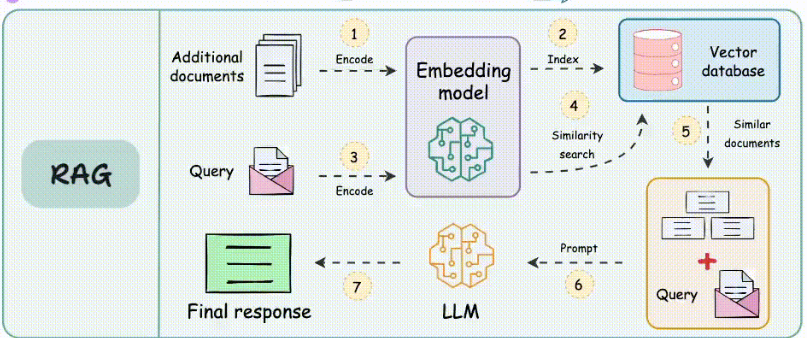

In [1]:
%load_ext autoreload
%autoreload 2

## Test LangChain

In [2]:
# libraries
import getpass
import os
import json

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import ChatOpenAI
from langchain_core.messages import (
    AnyMessage,
    SystemMessage,
    HumanMessage,
    ToolMessage,
    AIMessage,
)

model = ChatOpenAI(model="gpt-3.5-turbo")
message = [
    SystemMessage(content="Translate the following from English to German"),
    HumanMessage("Hello world!"),
]

result = model.invoke(message)

print(result)

content='Hallo Welt!' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 4, 'prompt_tokens': 21, 'total_tokens': 25, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None} id='run-b021ee47-aef4-4863-b5b0-bfd3c9470413-0' usage_metadata={'input_tokens': 21, 'output_tokens': 4, 'total_tokens': 25, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}


# Prepare Data

## Load files

In [3]:
%pip install -qU pypdf

Note: you may need to restart the kernel to use updated packages.


In [4]:
from pathlib import Path

pdf_path = Path("pdfs")
pdf_files = [f for f in pdf_path.iterdir() if f.suffix == ".pdf"]

print(f"Found {len(pdf_files)} PDF files.")

Found 3 PDF files.


[How to load PDFs | 🦜️🔗 LangChain](https://python.langchain.com/docs/how_to/document_loader_pdf/)

[PyPDFLoader — 🦜🔗 LangChain documentation](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.pdf.PyPDFLoader.html#langchain_community.document_loaders.pdf.PyPDFLoader.load_and_split)


In [5]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader(str(pdf_files[0]))
pages = []
async for page in loader.alazy_load():
    pages.append(page)

print(f"{pages[0].metadata}\n\n{pages[0].page_content}")

{'source': 'pdfs\\Ibarz et al. - 2021 - How to train your robot with deep reinforcement learning lessons we have learned.pdf', 'page': 0}

Article
The International Journal of
Robotics Research
2021, V ol. 40(4-5) 698–721
/C211The Author(s) 2021
Article reuse guidelines:
sagepub.com/journals-permissions
DOI: 10.1177/0278364920987859
journals.sagepub.com/home/ijr
How to train your robot with deep
reinforcement learning: lessons we have
learned
Julian Ibarz1 ,J i eT a n1, Chelsea Finn1,2, Mrinal Kalakrishnan3 ,
Peter Pastor3 and Sergey Levine1,4
Abstract
Deep reinforcement learning (RL) has emerged as a promising approach for autonomously acquiring complex behaviors
from low-level sensor observations. Although a large portion of deep RL research has focused on applications in video
games and simulated control, which does not connect with the constraints of learning in real environments, deep RL has
also demonstrated promise in enabling physical robots to learn complex skills in the real 

## Split
[Text splitters | 🦜️🔗 LangChain](https://python.langchain.com/docs/concepts/text_splitters/)

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)

docs = []

for pdf in pdf_files:
    loader = PyPDFLoader(str(pdf))
    docs.extend(loader.load())

splits = text_splitter.split_documents(docs)

Ignoring wrong pointing object 501 0 (offset 0)
Ignoring wrong pointing object 503 0 (offset 0)
Ignoring wrong pointing object 529 0 (offset 0)
Ignoring wrong pointing object 572 0 (offset 0)
Ignoring wrong pointing object 577 0 (offset 0)
Ignoring wrong pointing object 945 0 (offset 0)
Ignoring wrong pointing object 949 0 (offset 0)


## Embed
[Embedding models | 🦜️🔗 LangChain](https://python.langchain.com/docs/integrations/text_embedding/)

In [7]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

## [Vector stores | 🦜️🔗 LangChain](https://python.langchain.com/docs/integrations/vectorstores/)

Check for what you want to use, in this case we will use Chroma

[Vector stores | 🦜️🔗 LangChain](https://python.langchain.com/docs/concepts/vectorstores/) 

[Chroma | 🦜️🔗 LangChain](https://python.langchain.com/docs/integrations/vectorstores/chroma/)

In [8]:
%pip install -qU langchain-chroma

Note: you may need to restart the kernel to use updated packages.


In [9]:
from langchain.vectorstores import Chroma

persist_directory = Path("chroma_db")
if not persist_directory.exists():
    persist_directory.mkdir()

vector_store = Chroma.from_documents(
    splits, embeddings, persist_directory=str(persist_directory)
)

### Test simple search

In [10]:
results = vector_store.similarity_search("What is reinforcement learning?", k=2)
for r in results:
    print(f"* [{r.metadata['source']}] {r.page_content} ")

* [pdfs\Kober et al. - 2013 - Reinforcement learning in robotics A survey.pdf] strategy at the end of a phase of training or interaction. In the second, the goal is to
maximize the reward over the whole time the robot is interacting with the world.
In contrast to supervised learning, the learner must ﬁrst discover its environment and
is not told the optimal action it needs to take. To gain information about the rewards
and the behavior of the system, the agent needs to explore by considering previously
unused actions or actions it is uncertain about. It needs to decide whether to play it safe
and stick to well known actions with (moderately) high rewards or to dare trying new
things in order to discover new strategies with an even higherr e w a r d . T h i sp r o b l e mi s
commonly known as theexploration-exploitation trade-oﬀ.
In principle, reinforcement learning algorithms for MarkovD e c i s i o nP r o c e s s e sw i t h
performance guarantees are known (Kakade, 2003; Kearns andSin

# RAG using LangGraph

## Set up LangGraph

[LangGraph Glossary](https://langchain-ai.github.io/langgraph/concepts/low_level/#multiple-schemas)

[Document — 🦜🔗 LangChain documentation](https://python.langchain.com/api_reference/core/documents/langchain_core.documents.base.Document.html)

In [11]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

### create a prompt

In [12]:
from langchain.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate(
    [
        (
            "system",
            """You are an research assistant that answer question about research papers. \
            Use the following pieces of context to answer the question at the end. \
            """,
        ),
        ("user", "{context}"),
        ("user", "Question: {question}"),
    ]
)

test prompt

In [13]:
example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

In [14]:
example_messages

[SystemMessage(content='You are an research assistant that answer question about research papers.             Use the following pieces of context to answer the question at the end.             ', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='(context goes here)', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Question: (question goes here)', additional_kwargs={}, response_metadata={})]

### Create llm

In [15]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")

### Build the flow

In [16]:
from langgraph.graph import START, StateGraph


def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

display the graph

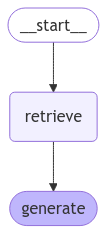

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

### Test with Question

In [18]:
question_1 = "How they use reinforcement learning in robot?"
question_2 = "What kind of methods are mentioned?"
question_3 = "How about deep reinforcement learning?"
question_4 = "How to combine (deep) reinforcement learning with robot?"

In [19]:
def ask_question_and_print_answer(question: str):
    result = graph.invoke({"question": question})
    print(result["answer"])

In [20]:
ask_question_and_print_answer(question_1)

Reinforcement learning (RL) is used in robots to enable them to autonomously learn and make decisions based on the feedback they receive from their environment. By implementing RL algorithms, robots can learn to perform tasks and navigate through complex environments without explicit programming. This allows robots to adapt to changing conditions and optimize their behavior over time through trial and error.


In [21]:
ask_question_and_print_answer(question_2)

The methods mentioned in the provided text are dynamic programming-based methods, rollout-based Monte Carlo methods, and temporal difference methods such as TD(λ), Q-learning, and SARSA.


In [22]:
ask_question_and_print_answer(question_3)

Deep reinforcement learning has shown significant success in various domains, including robot manipulation. By combining reinforcement learning algorithms with neural networks, machines have been able to learn complex tasks such as dexterous manipulation directly from raw pixel inputs. However, there are still limitations and challenges with current deep reinforcement learning algorithms that restrict their applicability in solving practical problems in robotics. Researchers are exploring future directions for deep reinforcement learning to address these issues and further advance the field.


In [23]:
ask_question_and_print_answer(question_4)

To combine (deep) reinforcement learning with robots, researchers have explored various approaches and algorithms. One common method is to train robots using reinforcement learning algorithms to perform specific tasks or interact with the environment. This involves defining a reward system that incentivizes desirable behavior and using deep neural networks to approximate the Q-values or policy functions necessary for decision-making.

Additionally, some studies have focused on multi-robot systems where multiple agents cooperate or compete using reinforcement learning to achieve collective goals. Cooperative learning among robots can lead to emergent behaviors and more efficient task completion.

Moreover, advancements in distributed reinforcement learning have enabled drones and other robots to learn from each other while operating in the same environment. This collaborative learning approach can improve overall system performance and adaptability.

Overall, combining reinforcement lea

## Add memory

In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_with_memory = graph_builder.compile(checkpointer=memory)

### Test the memory

In [25]:
def ask_question_with_memory_and_print_answer(question: str):
    config = {"configurable": {"thread_id": "1"}}
    result = graph_with_memory.invoke({"question": question}, config=config)
    print(result["answer"])

In [26]:
ask_question_with_memory_and_print_answer(question_4)

Combining (deep) reinforcement learning with robots involves integrating RL algorithms into the control systems of robots to enable them to learn and adapt their behaviors through interactions with their environment. This can be achieved by designing reward functions that guide the learning process, defining the state and action spaces for the robot, implementing neural network architectures for deep RL, and setting up training environments for the robot to learn and improve its performance over time. By combining RL with robots, they can acquire complex skills and behaviors that traditional programming methods may struggle to achieve, making them more adaptable and intelligent in various tasks and environments.


this answer is suspicious, let's check the content

In [27]:
from langchain.globals import set_verbose

set_verbose(True)

config = {"configurable": {"thread_id": "1"}}
graph_with_memory.invoke({"question": question_4}, config=config)

{'question': 'How to combine (deep) reinforcement learning with robot?',
 'context': [Document(metadata={'page': 4, 'source': 'pdfs\\Nguyen and La - 2019 - Review of Deep Reinforcement Learning for Robot Manipulation.pdf'}, page_content='solution can be reached by combining the advantages of some\nor all of them, or even maybe novel types of algorithms.\nHowever, from our point, RL in robot manipulation will have a\npromising future ahead. We believe that in order to build truly\nintelligent robots in the future, we would need something like\nRL algorithms.\nREFERENCES\n[1] H. M. La, R. Lim, and W. Sheng, “Multirobot cooperative learning for\npredator avoidance,”IEEE Transactions on Control Systems Technology,\nvol. 23, no. 1, pp. 52–63, 2015.\n[2] M. Rahimi, S. Gibb, Y . Shen, and H. M. La, “A comparison of various\napproaches to reinforcement learning algorithms for multi-robot box\npushing,” inIntern. Conf. on Engineering Research and Applications.\nSpringer, 2018, pp. 16–30.\n[3] H

In [28]:
question_5 = "What is most promising method?"
ask_question_with_memory_and_print_answer(question_5)

Based on the information provided, the most promising method in terms of data efficiency seems to be the model-based algorithm called Probabilistic Inference for Learning COntrol (PILCO) [15]. This method was able to learn a complex task such as the block-stacking task in just 4 minutes, showcasing its efficiency and effectiveness compared to other methods mentioned in the text.


In [29]:
question_6 = "What is the difference between PILCO and PPO and DDPG?"
ask_question_with_memory_and_print_answer(question_6)

PILCO (Probabilistic Inference for Learning Control) is a general strategy that combines policy search with the principle of optimality. It learns a non-stationary policy backward in time, similar to dynamic programming methods, without enforcing the Bellman equation. PILCO provides strong guarantees under function approximation and limited observability, making it useful for tasks like learning walking controllers and finding near-optimal trajectories for map exploration. However, PILCO is more computationally expensive than value function methods and scales quadratically with the effective time horizon of the problem. It is tied to a non-stationary (time-varying) policy.

PPO (Proximal Policy Optimization) is a reinforcement learning algorithm that aims to optimize the policy function in a stable and efficient manner. It addresses the limitations of traditional policy gradient methods by introducing a clipped surrogate objective function and a trust region constraint. PPO has been sh

In [30]:
question_7 = "who believes PILCO is the best?"
ask_question_with_memory_and_print_answer(question_7)

Based on the provided text, the current winner that is believed to be the best in terms of data efficiency is the model-based algorithm "shallow" algorithm Probabilistic Inference for Learning COntrol (PILCO), as mentioned in the text.


# Build a chatbot

manage memory external

In [31]:
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import START, StateGraph
from pathlib import Path

In [32]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [33]:
def load_db(pdf_files):
    # load
    docs = []
    for pdf in pdf_files:
        loader = PyPDFLoader(str(pdf))
        docs.extend(loader.load())

    # split
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    splits = text_splitter.split_documents(docs)

    # embed
    embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

    # vector store
    persist_directory = Path("chroma_db")
    if not persist_directory.exists():
        persist_directory.mkdir()

    vector_store = Chroma.from_documents(
        splits, embeddings, persist_directory=str(persist_directory)
    )

    # build langgraph
    ## prompt
    prompt = ChatPromptTemplate(
        [
            (
                "system",
                """You are an research assistant that answer question about research papers. \
                Use the following pieces of context to answer the question at the end. \
                """,
            ),
            ("user", "{context}"),
            ("user", "Question: {question}"),
        ]
    )

    llm = ChatOpenAI(model="gpt-3.5-turbo")

    def retrieve(state: State):
        retrieved_docs = vector_store.similarity_search(state["question"])
        return {"context": retrieved_docs}

    def generate(state: State):
        docs_content = "\n\n".join(doc.page_content for doc in state["context"])
        messages = prompt.invoke(
            {"question": state["question"], "context": docs_content}
        )
        response = llm.invoke(messages)
        return {"answer": response.content}

    graph_builder = StateGraph(State).add_sequence([retrieve, generate])
    graph_builder.add_edge(START, "retrieve")

    memory = MemorySaver()
    graph = graph_builder.compile(checkpointer=memory)
    return graph

In [37]:
import panel as pn

pn.extension()
import param


class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query = param.String("")
    db_response = param.List([])

    def __init__(self, **params):
        super(cbfs, self).__init__(**params)
        self.panels = []
        self.chat_history = []
        self.pdf_path = Path("pdfs")
        self.pdf_files = [f for f in pdf_path.iterdir() if f.suffix == ".pdf"]
        self.qa = load_db(self.pdf_files)

    def convchain(self, query):
        if not query:
            return
        inp.value = ""
        config = {"configurable": {"thread_id": "1"}}
        result = self.qa.invoke({"question": query}, config=config)
        self.answer = result["answer"]
        self.chat_history.extend([(query, self.answer)])
        self.panels.extend(
            [
                pn.Row("User:", pn.pane.Markdown(query, width=450)),
                pn.Row(
                    "ChatBot:",
                    pn.pane.Markdown(
                        self.answer, width=450, styles={"background-color": "#F6F6F6"}
                    ),
                ),
            ]
        )
        return pn.WidgetBox(*self.panels, scroll=True)

    @param.depends("convchain", "clr_history")
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(
                pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True
            )
        rlist = [
            pn.Row(
                pn.pane.Markdown(
                    f"Current Chat History variable",
                    styles={"background-color": "#F6F6F6"},
                )
            )
        ]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)

    def clr_history(self, count=0):
        self.chat_history = []
        return

In [38]:
cb = cbfs()

button_clearhistory = pn.widgets.Button(name="Clear History", button_type="warning")
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput(placeholder="Enter text here…")

conversation = pn.bind(cb.convchain, inp)

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation, loading_indicator=True, height=400),
    pn.layout.Divider(),
)

tab3 = pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown("# ChatWithYourData_Bot")),
    pn.Tabs(("Conversation", tab1), ("Chat History", tab3)),
)
dashboard

Ignoring wrong pointing object 501 0 (offset 0)
Ignoring wrong pointing object 503 0 (offset 0)
Ignoring wrong pointing object 529 0 (offset 0)
Ignoring wrong pointing object 572 0 (offset 0)
Ignoring wrong pointing object 577 0 (offset 0)
Ignoring wrong pointing object 945 0 (offset 0)
Ignoring wrong pointing object 949 0 (offset 0)


Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=Str, defer_load=False, height=400, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()

How to combine (deep) reinforcement learning with robot?

What is most promising method?

What is the difference between PILCO and PPO and DDPG?